Mean Squared Error: 36.090024676581535


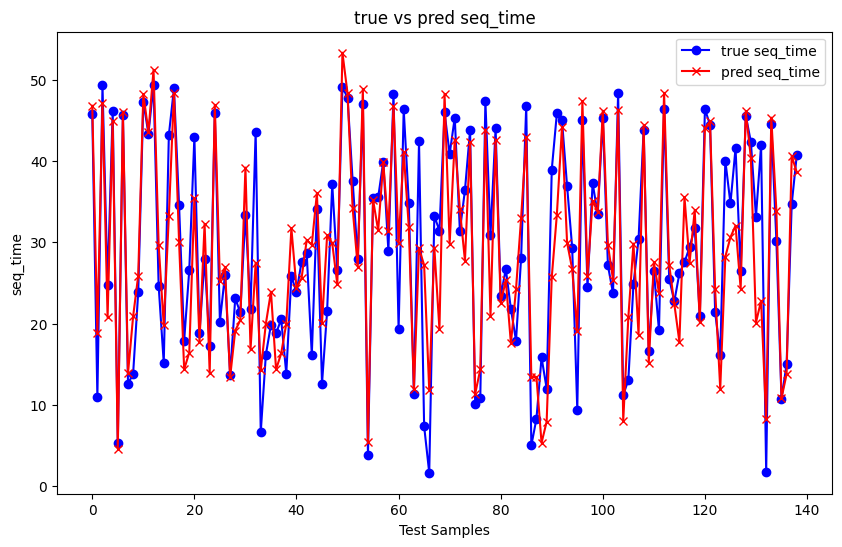

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import os
import numpy as np
import ast
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor


def get_files_by_keywords(directory, keywords):
    # 遍历指定文件夹，根据关键字数组提取文件。
    matched_files = []
    for filename in os.listdir(directory):
        if all(keyword in filename for keyword in keywords):
            matched_files.append(filename)
    return matched_files


def process_array_string(array_string):
    # 去掉最大值、最小值并计算平均值
    # 如果输入是单个值，则直接返回
    if isinstance(array_string, (int, float)):
        return array_string
    # 将字符串转换为列表
    values = ast.literal_eval(array_string)
    # 如果列表长度大于2，去掉最大值和最小值
    if len(values) > 2:
        values.remove(max(values))
        values.remove(min(values))
    mean_value = np.mean(values)
    return mean_value


##### 修改这里 #####
ap_name = "3ap"
project_root = "/Users/daylight/Desktop/macos/1Code/Competition/2024ShuMo"
data_dir = project_root + "/data/results/B_add_column"
training_data_names = get_files_by_keywords(data_dir, ["training", ap_name, "csv"])
training_data_all_path = project_root + f"/data/processed/training_data_{ap_name}.csv"
os.makedirs(os.path.dirname(training_data_all_path), exist_ok=True)
training_data_names = sorted(training_data_names)
#### 读取所有训练数据 #####
training_data_all = pd.DataFrame()
# 初始化一个变量来追踪全局的最大 test_id
current_max_test_id = 0
file_split_id = []  # 记录分隔文件的id位置
for file in training_data_names:
    file_path = os.path.join(data_dir, file)
    df = pd.read_csv(file_path)
    # 获取当前合并DataFrame中的最大test_id，如果为空则设置为0
    if not training_data_all.empty:
        max_test_id = training_data_all["test_id"].max()
    else:
        max_test_id = 0
    # 调整新df的test_id，保证test_id连续递增
    df["test_id"] = df["test_id"] + max_test_id
    # 将当前DataFrame追加到总的training_data_all中
    training_data_all = pd.concat([training_data_all, df], ignore_index=True)
    file_split_id.append(training_data_all["test_id"].max())

columns_class = ["ap_id", "sta_id"]
columns_numerical = ["eirp", "nav", "eirp_threshold"]
columns_basic = ["test_id", "seq_time", "loc_id", "protocol", "eirp", "nav"] + columns_numerical
# protocol_name = ["tcp", "udp"]

### 提取对应的列rssi ###
ap_0_sta_0 = ["ap_from_ap_1_mean_ant_rssi", "ap_from_ap_2_mean_ant_rssi", "sta_to_ap_0_mean_ant_rssi", "sta_to_ap_1_mean_ant_rssi", "sta_to_ap_2_mean_ant_rssi", "sta_from_ap_0_mean_ant_rssi", "sta_from_ap_1_mean_ant_rssi", "sta_from_ap_2_mean_ant_rssi", "sta_from_sta_1_rssi", "sta_from_sta_2_rssi"]
ap_1_sta_1 = ["ap_from_ap_0_mean_ant_rssi", "ap_from_ap_2_mean_ant_rssi", "sta_to_ap_0_mean_ant_rssi", "sta_to_ap_1_mean_ant_rssi", "sta_to_ap_2_mean_ant_rssi", "sta_from_ap_0_mean_ant_rssi", "sta_from_ap_1_mean_ant_rssi", "sta_from_ap_2_mean_ant_rssi", "sta_from_sta_0_rssi", "sta_from_sta_2_rssi"]
ap_2_sta_2 = ["ap_from_ap_0_mean_ant_rssi", "ap_from_ap_1_mean_ant_rssi", "sta_to_ap_0_mean_ant_rssi", "sta_to_ap_1_mean_ant_rssi", "sta_to_ap_2_mean_ant_rssi", "sta_from_ap_0_mean_ant_rssi", "sta_from_ap_1_mean_ant_rssi", "sta_from_ap_2_mean_ant_rssi", "sta_from_sta_0_rssi", "sta_from_sta_1_rssi"]

training_data_all_ap_0 = training_data_all.loc[training_data_all["ap_id"] == "ap_0"].copy()
for i, column in enumerate(ap_0_sta_0):
    training_data_all_ap_0[column] = training_data_all_ap_0[column].apply(process_array_string)

training_data_all_ap_1 = training_data_all.loc[training_data_all["ap_id"] == "ap_1"].copy()
for i, column in enumerate(ap_1_sta_1):
    training_data_all_ap_1[ap_0_sta_0[i]] = training_data_all_ap_1[column].apply(process_array_string)

training_data_all_ap_2 = training_data_all.loc[training_data_all["ap_id"] == "ap_2"].copy()
for i, column in enumerate(ap_2_sta_2):
    training_data_all_ap_2[ap_0_sta_0[i]] = training_data_all_ap_2[column].apply(process_array_string)

training_data_all_processed = pd.concat([training_data_all_ap_0[columns_basic + ap_0_sta_0], training_data_all_ap_1[columns_basic + ap_0_sta_0]], ignore_index=True)
training_data_all_processed = pd.concat([training_data_all_processed, training_data_all_ap_2[columns_basic + ap_0_sta_0]], ignore_index=True)

######## 训练模型 #######
# 去掉空值
training_data = training_data_all_processed.loc[:, columns_basic + ap_0_sta_0].dropna().copy()
# 编码非数值变量
training_data_encoded = pd.get_dummies(training_data, columns=["loc_id", "protocol"])

# 拼接向量
X = training_data_encoded[columns_numerical + ap_0_sta_0 + [col for col in training_data_encoded.columns if col.startswith("loc_id_") or col.startswith("protocol_")]]
y = training_data_encoded["seq_time"]

# 将数据分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 归一化特征
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### 模型训练 ####
# 线性回归
# model = LinearRegression()
# XGBoost
model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
# 随机森林
# model = RandomForestRegressor(random_state=42)
# 支持向量回归
# model = SVR(kernel='rbf')
# 神经网络回归模型
# model = MLPRegressor(hidden_layer_sizes=(128,64,32), max_iter=1000, alpha=0.001, random_state=42)

# 训练模型
model.fit(X_train_scaled, y_train)
# 对测试集进行预测
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# 对比曲线图：真实值 vs 预测值
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(y_test)), y_test, label="true seq_time", color="blue", marker="o")
plt.plot(np.arange(len(y_pred)), y_pred, label="pred seq_time", color="red", marker="x")
plt.xlabel("Test Samples")
plt.ylabel("seq_time")
plt.title("true vs pred seq_time")
plt.legend()
plt.show()

#### 只有树模型才有
# 打印每个特征的重要性
# importance = model.feature_importances_
# # 可视化特征重要性
# plt.figure(figsize=(10, 6))
# plt.barh(X_train.columns, importance)
# plt.xlabel("Feature Importance")
# plt.ylabel("Features")
# plt.title("Feature Importance Analysis")
# plt.show()